# Clustering the Beaded Helix Transtion from R- to L-Helix

## Import Libraries

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
#from shapeGMMTorch.utils import cross_validate_component_scan, sgmm_fit_with_attempts
import MDAnalysis as md
import torch
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Read trajectory

In [3]:
prmtopFileName = "helix_template.pdb"
trajFileName = "helix_folding_eps6.0.dcd"
coord = md.Universe(prmtopFileName,trajFileName)
print("Number of atoms in trajectory:", coord.atoms.n_atoms)
print("Number of frames in trajectory:", coord.trajectory.n_frames)
# make atom selection
atomSel = coord.select_atoms('all')
print("Number of atoms in selection:", atomSel.n_atoms)
# create traj data of selection
traj_data = np.empty((coord.trajectory.n_frames,atomSel.n_atoms,3),dtype=float)
#loop traj
for ts in coord.trajectory:
    traj_data[ts.frame,:] = atomSel.positions

Number of atoms in trajectory: 12
Number of frames in trajectory: 10001
Number of atoms in selection: 12


## Perform Cross Validation Component Scan (can take a while)

In [3]:
# define cluster array
component_array = np.arange(1,6,1).astype(int)
print(component_array)

[1 2 3 4 5]


In [3]:
covar_type = "kronecker"
device = torch.device("cpu")
dtype  = torch.float64

In [6]:
# run component CV scan
n_training_sets = 3
n_attempts = 10
train_log_lik, predict_log_lik = cross_validate_component_scan(traj_data,component_array, 
                                                                                 covar_type = "kronecker", 
                                                                                 n_training_sets=n_training_sets,
                                                                                 n_attempts=n_attempts,
                                                                                 device = device,
                                                                                 dtype=dtype
                                                                                )

Number of atoms: 12
Covariance type: kronecker
Number of frames to train each model: 9000
Number of frames to predict each model: 1001
Number of training sets: 3
Number of attempts per set/component: 10
Component array: [1 2 3 4 5]
Init Component Method   : kmeans++
Random seed             : 1234
   Training Set    N Components         Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------------------------------------
              1               1               1             35.6470           0.491
              1               2               1             39.3179          13.061
              1               2               2             39.9073           0.984
              1               2               3             40.1596           2.861
              1               2               4             39.9067           1.793
              1               2               5             40.2009           3.117
              1     

In [7]:
# write to data files
np.savetxt("train_1_5.dat",np.column_stack((component_array,train_log_lik)))
np.savetxt("predict_1_5.dat",np.column_stack((component_array,predict_log_lik)))

In [4]:
# load data from txt file if you don't want to run
train_log_lik = np.loadtxt("train_1_5.dat")[:,1:]
predict_log_lik = np.loadtxt("predict_1_5.dat")[:,1:]

## Make Log Likelihood vs number of Cluster Plots

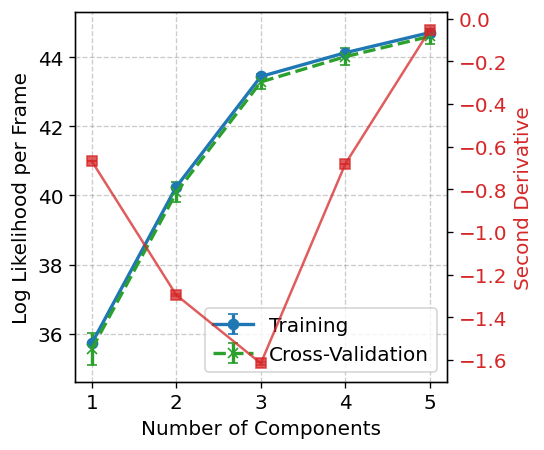

In [8]:
# shapeGMMTorch plots has a built-in plot function for this type of plot
from shapeGMMTorch.utils import plotting
# create figure
fig, ax = plt.subplots(1,1,figsize=(4,4), dpi= 120, facecolor='w', edgecolor='k')
plotting.plot_log_likelihood_with_dd(ax,component_array,train_log_lik,predict_log_lik,fontsize=12,ylabel1=True,ylabel2=True,xlabel=True)

## Run WSGMM for nClusters=3

In [9]:
# fit a shapeGMM object for n=4 with metaD weights trained on every other frame
# shapeGMMTorch has a built-in script for this
n_clusters = 3
delta = 1
n_attempts = 20
sgmm3 = sgmm_fit_with_attempts(traj_data[::delta], n_clusters, n_attempts, device=device, dtype=dtype)

Number of components    : 3
Number of attempts      : 20
Covariance type         : kronecker
Data type (dtype)       : torch.float64
Device                  : cpu
Number of train frames  : 10001
Number of atoms         : 12
Init Component Method   : kmeans++
Random seed             : 1234
 Attempt  Log Like per Frame Wallclock Time (s)
------------------------------------------------------------
       1             43.0930           2.092
       2             43.0887           1.599
       3             43.1146           1.320
       4             43.1210           1.694
       5             43.1203           2.591
       6             43.0882           1.296
       7             43.1216           1.792
       8             43.0922           1.422
       9             43.1204           1.682
      10             43.0993           2.224
      11             43.4365           5.066
      12             43.1155           1.440
      13             43.1100           2.457
      14        

In [10]:
#predict if you didn't train on entire data set
entire_traj_clusters = sgmm3.predict(traj_data)

## Make 2D FE Plot with clusterings

In [11]:
from shapeGMMTorch import align

In [12]:
traj_tensor = torch.tensor(traj_data,dtype=dtype,device=device)
ref = torch.tensor(sgmm3.means_[0],dtype=dtype,device=device)
prec = torch.tensor(sgmm3.precisions_[0],dtype=torch.float64,device=device)
aligned_traj_1 = align.align_kronecker(traj_tensor,ref,prec)
aligned_traj_1 = aligned_traj_1.cpu().numpy()
ref = torch.tensor(sgmm3.means_[1],dtype=dtype,device=device)
prec = torch.tensor(sgmm3.precisions_[1],dtype=torch.float64,device=device)
aligned_traj_2 = align.align_kronecker(traj_tensor,ref,prec)
aligned_traj_2 = aligned_traj_2.cpu().numpy()

In [13]:
def maha_dist2_trajectory(x1, x2, weights):
    """
    Compute the squared Mahalanobis distance between a trajectory and a reference structure
    using a fixed per-coordinate inverse covariance matrix.

    Parameters
    ----------
    x1 : np.ndarray
        Array of shape (n_frames, n_atoms, 3) representing trajectory frames.
    x2 : np.ndarray
        Array of shape (n_atoms, 3) representing the reference structure.
    weights : np.ndarray
        Array of shape (n_atoms, n_atoms), the inverse covariance matrix applied independently to each coordinate axis.

    Returns
    -------
    dist : np.ndarray
        Array of shape (n_frames,) with the squared Mahalanobis distance for each frame.
    """
    # Compute displacements: shape (n_frames, n_atoms, 3)
    disp = x1 - x2[None, :, :]  # broadcast x2 across frames

    # Initialize distance array
    dist = np.zeros(x1.shape[0], dtype=np.float64)

    # Sum Mahalanobis distances across coordinates
    for i in range(3):
        d = disp[:, :, i]  # shape (n_frames, n_atoms)
        dist += np.einsum("fi,ij,fj->f", d, weights, d)

    return dist

In [14]:
maha1 = np.sqrt(maha_dist2_trajectory(aligned_traj_1,sgmm3.means_[0],sgmm3.precisions_[0]))
maha2 = np.sqrt(maha_dist2_trajectory(aligned_traj_2,sgmm3.means_[1],sgmm3.precisions_[1]))

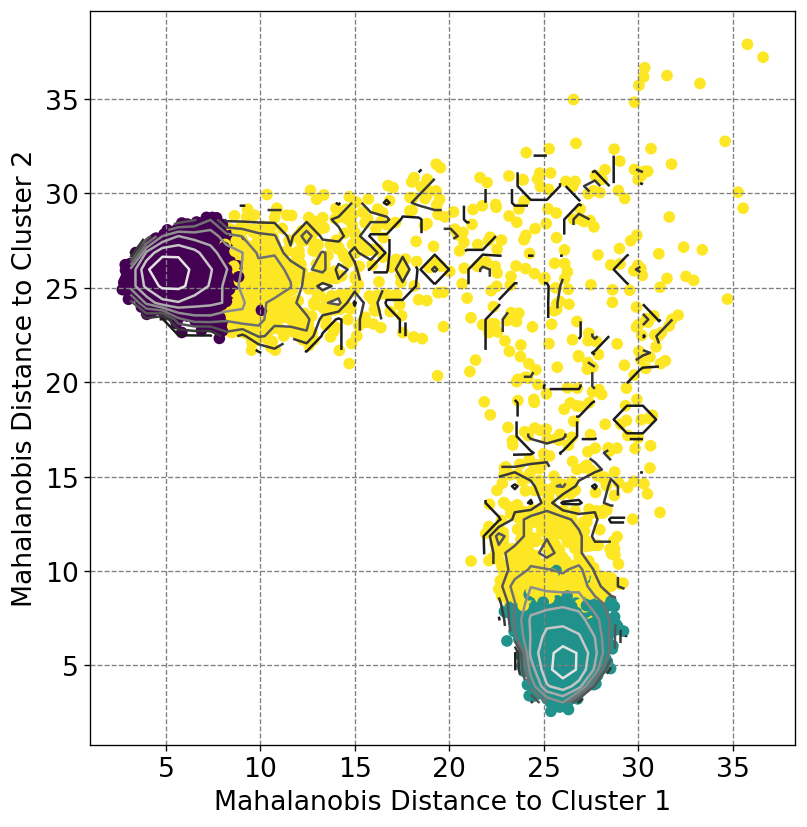

In [15]:
plt.figure(figsize=(7,7), dpi= 120, facecolor='w', edgecolor='k')
x = maha1
y = maha2
H, xedges, yedges = np.histogram2d(x,y,bins=40,density=True)
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
H = -np.log(H.T)
xx, yy = np.meshgrid(xcenters, ycenters)
plt.contour(xx,yy,H,cmap='binary')
plt.ylabel("Mahalanobis Distance to Cluster 2",fontsize=16)
plt.xlabel("Mahalanobis Distance to Cluster 1",fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.scatter(maha1,maha2,c=entire_traj_clusters)#,alpha=0.2)
plt.tight_layout()
#plt.xlim(0,38)
#plt.ylim(0,38)
plt.gca().set_aspect('equal');
#plt.savefig("beaded_helix_2D_FE_w_clusters.eps",dpi=300)